In [170]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
import math
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from torch.autograd import Variable
import sys
import scipy.io as sio
import pdb
%matplotlib inline

#Wireless Parameters
N_t = 64
N_r = 16
latent_dim = 35

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    dtype_long = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor

class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# custom con2d, because pytorch don't have "padding='same'" option.
def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows - input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] + (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    # same for padding_cols
    input_cols = input.size(3)
    filter_cols = weight.size(3)
    effective_filter_size_cols = (filter_cols - 1) * dilation[0] + 1
    out_cols = (input_cols + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_cols - 1) * stride[0] + effective_filter_size_cols - input_cols)
    padding_cols = max(0, (out_cols - 1) * stride[0] + (filter_cols - 1) * dilation[0] + 1 - input_cols)
    cols_odd = (padding_cols % 2 != 0)
    if rows_odd or cols_odd:
        input = F.pad(input, [0, int(cols_odd), 0, int(rows_odd)])
    return F.conv2d(input, weight, bias, stride, padding=(padding_rows // 2, padding_cols // 2),dilation=dilation, groups=groups)
    
class View(torch.nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
    
class Concatenate(torch.nn.Module):
    def __init__(self, axis):
        super(Concatenate, self).__init__()
        self.axis = axis

    def forward(self, x):
        return torch.cat((x[0],x[1]),self.axis)

In [185]:
length = int(N_t/4)
breadth = int(N_r/4)
latent_dim = 65
class Generator(torch.nn.Module):
    def __init__(self,mb_size):
        super(Generator,self).__init__()
        self.mb_size = mb_size
        self.embedding = torch.nn.Embedding(2,10)
        self.linear_e = torch.nn.Linear(10,length*breadth)
        self.view_e = View([mb_size,1,length,breadth])
        self.linear_g1 = torch.nn.Linear(latent_dim, 127*length*breadth)
        self.relu = torch.nn.ReLU()
        self.view_g = View([mb_size,127,length,breadth])
        self.upsample_g = torch.nn.Upsample(scale_factor=2)
        self.batchnorm_g1 = torch.nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g2 = torch.nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g3 = torch.nn.BatchNorm2d(128,momentum=0.8)
        self.conv2d_g1 = Conv2d(128,128,4,bias=False)
        self.conv2d_g2 = Conv2d(128,128,4,bias=False)
        self.conv2d_g4 = Conv2d(128,128,4,bias=False)
        self.conv2d_g3 = Conv2d(128,2,4,bias=False)
        self.concat = Concatenate(1)
        
    def forward(self,z,c):
        c_e = self.embedding(c)
        c_l = self.linear_e(c_e)
        c_v = self.view_e(c_l)
        
        z1 = self.linear_g1(z)
        z1 = self.relu(z1)
        z1_v = self.view_g(z1)
        
        z_c = self.concat([z1_v,c_v])
        z_c_1 = self.upsample_g(z_c)
        z_c_1 = self.conv2d_g1(z_c_1)
        z_c_1 = self.batchnorm_g1(z_c_1)
        z_c_1 = self.relu(z_c_1)
        z_c_2 = self.upsample_g(z_c_1)
        z_c_2 = self.conv2d_g2(z_c_2)
        z_c_2 = self.batchnorm_g2(z_c_2)
        z_c_2 = self.relu(z_c_2)
        z_c_2 = self.conv2d_g4(z_c_2)
        z_c_2 = self.batchnorm_g3(z_c_2)
        z_c_2 = self.relu(z_c_2)
        output = self.conv2d_g3(z_c_2)
        
        return output

G_test = Generator(1).type(dtype)
G_test.load_state_dict(torch.load('../Final/checkpoints/CWGAN/ld_65/v1/reset_optim_D/generator_CDL_ABCDE_ld_35_FFT.pt'))
G_test.eval()

Generator(
  (embedding): Embedding(2, 10)
  (linear_e): Linear(in_features=10, out_features=64, bias=True)
  (view_e): View()
  (linear_g1): Linear(in_features=65, out_features=8128, bias=True)
  (relu): ReLU()
  (view_g): View()
  (upsample_g): Upsample(scale_factor=2.0, mode=nearest)
  (batchnorm_g1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (batchnorm_g2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (batchnorm_g3): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2d_g1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g3): Conv2d(128, 2, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (concat): Concatenate()
)

In [246]:
length = int(N_t/4)
breadth = int(N_r/4)
latent_dim = 65

G_test = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 128*length*breadth),
    torch.nn.ReLU(),
    View([1,128,length,breadth]),
    torch.nn.Upsample(scale_factor=2),
    Conv2d(128,128,4,bias=False),
    torch.nn.BatchNorm2d(128,momentum=0.8),
    torch.nn.ReLU(),
    torch.nn.Upsample(scale_factor=2),
    Conv2d(128,128,4,bias=False),
    torch.nn.BatchNorm2d(128,momentum=0.8),
    torch.nn.ReLU(),
    Conv2d(128,2,4,bias=False),
)
G_test = G_test.type(dtype)
G_test.load_state_dict(torch.load('../Final/checkpoints/WGAN/CDL-E/ld_65/reset_optim_D/generator36000.pt'))
G_test.eval()

Sequential(
  (0): Linear(in_features=65, out_features=8192, bias=True)
  (1): ReLU()
  (2): View()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Upsample(scale_factor=2.0, mode=nearest)
  (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(128, 2, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [165]:
import copy
def fft_op(H_extracted):
    for i in range(H_extracted.shape[0]):
        H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
    return H_extracted
    
H_org_A = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_A_ULA_clean.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_extracted_A = fft_op(H_extracted_A)
H_org_B = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_B_ULA_clean.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_extracted_B = fft_op(H_extracted_B)
H_org_C = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_C_ULA_clean.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_extracted_C = fft_op(H_extracted_C)
H_org_D = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_D_ULA_clean.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_extracted_D = fft_op(H_extracted_D)
H_org_E = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_clean.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))
H_extracted_E = fft_op(H_extracted_E)

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)

img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)
mu_real = np.mean(img_np_real,axis=0)
mu_imag = np.mean(img_np_imag,axis=0)
std_real = np.std(img_np_real,axis=0)
std_imag = np.std(img_np_imag,axis=0)

A_T_R = np.kron(A_T.conj(),A_R)
A_T_R_real = dtype(np.real(A_T_R))
A_T_R_imag = dtype(np.imag(A_T_R))

H_org_A = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_A_ULA_test.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_org_B = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_B_ULA_test.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_org_C = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_C_ULA_test.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_org_D = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_D_ULA_test.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_org_E = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)
H_extracted = fft_op(H_extracted)
H_ex = np.concatenate([H_ex_A,H_ex_B,H_ex_C,H_ex_D,H_ex_E],axis=2)

In [247]:
import copy
H_org = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_clean.mat")
H_ex = H_org['hest']
H_extracted = np.transpose(copy.deepcopy(H_ex),(2,1,0))
dft_basis = sio.loadmat("../CS-GAN-21_22/data/dft_basis.mat")
A_T = dft_basis['A1']/np.sqrt(N_t)
A_R = dft_basis['A2']/np.sqrt(N_r)
for i in range(H_ex.shape[2]):
    H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))

img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)

mu_real = np.mean(img_np_real,axis=0)
mu_imag = np.mean(img_np_imag,axis=0)
std_real = np.std(img_np_real,axis=0)
std_imag = np.std(img_np_imag,axis=0)

H_org = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex = H_org['hest']
H_extracted = np.transpose(copy.deepcopy(H_ex),(2,1,0))
for i in range(H_ex.shape[2]):
    H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)
img_np_real = (img_np_real - mu_real)/std_real
img_np_imag = (img_np_imag - mu_imag)/std_imag

In [248]:
N_s = N_r
N_rx_rf = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

ntest = 20              
nrepeat = 5 #Different noise realizations
SNR_vec = range(-15,20,5)
alpha = 0.4
ct = 0
N_p = int(alpha*N_t)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])
identity = np.identity(N_r)

size = int(H_extracted.shape[0]/5)
CDL_NLOS = np.ones((3*size,1))
CDL_LOS = 2*np.ones((2*size,1))
CDL = np.concatenate((CDL_NLOS,CDL_LOS),axis=0)

In [189]:
nmse_1bitQ_CWGAN = np.zeros((128,len(SNR_vec)))
ct = 0
lambda_reg = 1e-2
lambda_d = 1e-3
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        symbols = qpsk_constellation[pilot_sequence_ind]
        precoder_training = training_precoder(N_t,N_s)
        W = training_combiner(N_r,N_rx_rf)
        A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
        A_real = dtype(np.real(A))
        A_imag = dtype(np.imag(A))
        for ind in range(0,H_ex.shape[2],2):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            sign_vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
            #dither = np.random.uniform(-lambda_d,lambda_d,(N_r,N_p))
            rx_signal = signal + np.multiply(std_dev,noise_matrix) #+ dither
            rx_signal = np.matmul(W,rx_signal)
            vec_y[:,0,0] = rx_signal.flatten('F') 
            sign_vec_y_real = dtype(np.sign(np.real(vec_y[:,:,0])))
            sign_vec_y_imag = dtype(np.sign(np.imag(vec_y[:,:,0])))
            
            def gen_output_obq(x,c):
                pred = G_test(x,c)
                pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                A_G_real = torch.mm(A_real,pred_real) - torch.mm(A_imag,pred_imag)
                A_G_imag = torch.mm(A_real,pred_imag) + torch.mm(A_imag,pred_real)
                loss1 = (torch.sum(torch.mul(sign_vec_y_real,A_G_real)) + torch.sum(torch.mul(sign_vec_y_imag,A_G_imag)))
                #loss2 = (2*lambda_d/(N_s*N_p))*torch.norm(pred)**2
                return -loss1 #loss2 
            
            x = Variable(torch.randn(1, latent_dim)).type(dtype)
            c = torch.from_numpy(np.array([CDL[ind,0]-1])).long().type(dtype_long)
            x.requires_grad = True
            learning_rate = 1e-1
            optimizer = torch.optim.Adam([x], lr=learning_rate)
            for a in range(500): 
                optimizer.zero_grad()
                loss = gen_output_obq(x,c)
                loss.backward()
                optimizer.step()
            gen_imgs = G_test(x,c).data.cpu().numpy()
            gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
            gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
            gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
            gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
            alph = np.sum(np.conj(gen_imgs_complex) * vec_H_single) / np.sum(np.conj(gen_imgs_complex) * gen_imgs_complex)
            nmse_1bitQ_CWGAN[int(ind/2),ct-1] = nmse_1bitQ_CWGAN[int(ind/2),ct-1] + (np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
            print((np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_1bitQ_CWGAN = nmse_1bitQ_CWGAN/(nrepeat)

0.9974020689101589
0.9994681075444212
0.9947503539360057
0.9597356630366457
0.9983484921649493
0.9455920185133988
0.9969606663301133
0.9779200658398274
0.985032879379756
0.9605817564210296
0.869540222985187
0.9994794707747388
0.9409614183063597
0.9981293241122066
0.9443911257260699
0.9968460396467507
0.9958159211443897
0.9989021086667293
0.9843827391291254
0.8496399683014801
0.9924483373130059
0.9564710575291865
0.9337335372028428
0.9875436747668813
0.9678173518989002
0.9642902954104191
0.9884539240751208
0.9915851134622733
0.9972565927997364
0.969151103351203
0.9499359704390125
0.9989392619437115
0.8847098303331887
0.9902810118726421
0.9930866166836635
0.9938447769503703
0.9951940756021578
0.9049461291868072
0.9824524883116981
0.974291866104874
0.9027654117556215
0.9985376402645154
0.9706263730612588
0.9929405294802249
0.9964516170896202
0.9584939604286299
0.9801086981376775
0.9822676906830875
0.9161278269517357
0.9908294093487537
0.9977289660634641
0.9592875125596886
0.96109821414057

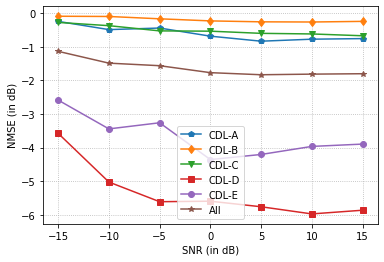

In [190]:
nmse_ABCDE = np.zeros((5,len(SNR_vec)))
nmse_ABCDE[0,:] = np.mean(nmse_1bitQ_CWGAN[0:26,:],axis=0)
nmse_ABCDE[1,:] = np.mean(nmse_1bitQ_CWGAN[26:51,:],axis=0)
nmse_ABCDE[2,:] = np.mean(nmse_1bitQ_CWGAN[51:77,:],axis=0)
nmse_ABCDE[3,:] = np.mean(nmse_1bitQ_CWGAN[77:104,:],axis=0)
nmse_ABCDE[4,:] = np.mean(nmse_1bitQ_CWGAN[104:,:],axis=0)
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[0,:]),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[1,:]),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[2,:]),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[3,:]),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[4,:]),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_1bitQ_CWGAN,axis=0)),'*-',label='All')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

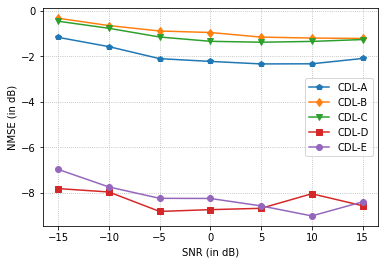

In [157]:
nmse_embgamp = sio.loadmat('../CS-GAN-21_22/nmse_1bit.mat')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_A),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_B),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_D),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_E),'o-',label='CDL-E')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

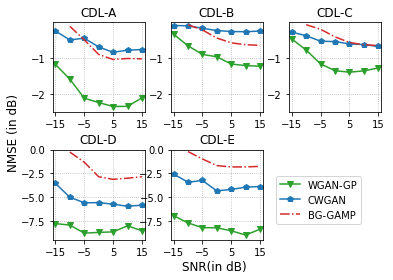

In [261]:
nmse_emgmamp = sio.loadmat('../CS-GAN-21_22/nmse_1bit.mat')
SNR_vec = range(-15,20,5)
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_A),'v-',label='WGAN-GP',color='#2ca02c')
ax1.plot(SNR_vec,10*np.log10(nmse_ABCDE[0,:]),'p-',label='CWGAN',color='#1f77b4')
ax1.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_A']),'-.',label='BG-GAMP',color='#d62728')
ax1.grid(ls=':')
ax1.set_xlim([-16,16]); ax1.set_ylim([-2.5,0]); ax1.set_xticks((-15,-5,5,15)); ax1.set_yticks([-2,-1])

ax2.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_B),'v-',label='WGAN-GP',color='#2ca02c')
ax2.plot(SNR_vec,10*np.log10(nmse_ABCDE[1,:]),'p-',label='CWGAN',color='#1f77b4')
ax2.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_B']),'-.',label='BG-GAMP',color='#d62728')
ax2.grid(ls=':')
ax2.set_xlim([-16,16]); ax2.set_ylim([-2.5,0]); ax2.set_xticks((-15,-5,5,15)); ax2.set_yticks([-2,-1])

ax3.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='WGAN-GP',color='#2ca02c')
ax3.plot(SNR_vec,10*np.log10(nmse_ABCDE[2,:]),'p-',label='CWGAN',color='#1f77b4')
ax3.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_C']),'-.',label='BG-GAMP',color='#d62728')
ax3.grid(ls=':')
ax3.set_xlim([-16,16]); ax3.set_ylim([-2.5,0]); ax3.set_xticks((-15,-5,5,15)); ax3.set_yticks([-2,-1])

ax4.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_D),'v-',label='WGAN-GP',color='#2ca02c')
ax4.plot(SNR_vec,10*np.log10(nmse_ABCDE[3,:]),'p-',label='CWGAN',color='#1f77b4')
ax4.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_D']),'-.',label='BG-GAMP',color='#d62728')
ax4.grid(ls=':')
ax4.set_xlim([-16,16]); ax4.set_ylim([-9.5,0]); ax4.set_xticks((-15,-5,5,15)); ax4.set_yticks([-7.5,-5,-2.5,0])

ax5.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_E),'v-',label='WGAN-GP',color='#2ca02c')
ax5.plot(SNR_vec,10*np.log10(nmse_ABCDE[4,:]),'p-',label='CWGAN',color='#1f77b4')
ax5.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_E']),'-.',label='BG-GAMP',color='#d62728')
ax5.grid(ls=':')
ax5.set_xlim([-16,16]); ax5.set_ylim([-9.5,0]); ax5.set_xticks((-15,-5,5,15)); ax5.set_yticks([-7.5,-5,-2.5,0])

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('NMSE (in dB)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7,0.2))
plt.savefig('results/1bitQ_NMSE_SNR.pdf',dpi=50000)

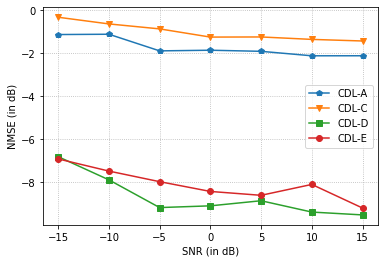

In [139]:
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_A),'p-',label='CDL-A')
#plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_B),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_C),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_D),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_E),'o-',label='CDL-E')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

In [249]:
#Few bit Quantization
#nmse_1bitQ_CDL_A = np.zeros((len(SNR_vec),1))
capacity_1bitQ_CDL_E = np.zeros((len(SNR_vec),1))
capacity_compute = 1
Lloyd_stepsize_vector = np.array([1.5956, 0.9957, 0.586, 0.3352, 0.1881,0.1041,0.0569, 0.0308])
stepsize_scale_factor = 1
bit = 1
def rms(y):
    return np.sqrt(np.mean(y**2))

ct = 0
lambda_reg = 1e-2
lambda_d = 1e-3
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        symbols = qpsk_constellation[pilot_sequence_ind]
        precoder_training = training_precoder(N_t,N_s)
        W = training_combiner(N_r,N_rx_rf)
        A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
        A_real = dtype(np.real(A))
        A_imag = dtype(np.imag(A))
        for ind in range(ntest):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            sign_vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
            rx_signal = signal + np.multiply(std_dev,noise_matrix)
            rx_signal = np.matmul(W,rx_signal)
            vec_y[:,0,0] = rx_signal.flatten('F') 
            
            #Few bit Quantization
            stepsize = stepsize_scale_factor * rms(np.array([np.real(vec_y[:,:,0]), np.imag(vec_y[:,:,0])]))* Lloyd_stepsize_vector[bit-1];
            dither_mean = rms(np.array([np.real(vec_y[:,:,0]), np.imag(vec_y[:,:,0])]));
            
            sign_vec_y_real = dtype(np.multiply(np.sign(np.real(vec_y[:,:,0])),(np.minimum(np.ceil(np.abs(np.real(vec_y[:,:,0]))/stepsize) , 2**(bit-1)) - 1/2)) * stepsize)
            sign_vec_y_imag = dtype(np.multiply(np.sign(np.imag(vec_y[:,:,0])),(np.minimum(np.ceil(np.abs(np.imag(vec_y[:,:,0]))/stepsize) , 2**(bit-1)) - 1/2)) * stepsize)
            
            def gen_output_obq(x):
                pred = G_test(x)
                pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                A_G_real = torch.mm(A_real,pred_real) - torch.mm(A_imag,pred_imag)
                A_G_imag = torch.mm(A_real,pred_imag) + torch.mm(A_imag,pred_real)
                loss1 = (torch.sum(torch.mul(sign_vec_y_real,A_G_real)) + torch.sum(torch.mul(sign_vec_y_imag,A_G_imag)))
                return -loss1 
            
            x = Variable(torch.randn(1, latent_dim)).type(dtype)
            x.requires_grad = True
            learning_rate = 1e-1
            optimizer = torch.optim.Adam([x], lr=learning_rate)
            for a in range(500): 
                optimizer.zero_grad()
                loss = gen_output_obq(x)
                loss.backward()
                optimizer.step()
            gen_imgs = G_test(x).data.cpu().numpy()
            gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
            gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
            gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
            gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
            alph = np.sum(np.conj(gen_imgs_complex) * vec_H_single) / np.sum(np.conj(gen_imgs_complex) * gen_imgs_complex)
            #pdb.set_trace()
            #nmse_3bitQ_CDL_E[ct-1,0] = nmse_3bitQ_CDL_E[ct-1,0] + (np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
            #print((np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)

            #Capacity Computation
            if capacity_compute == 1:
                H = np.reshape(alph*gen_imgs_complex,[N_r,N_t],order='F')
                U,S,VH = np.linalg.svd(H,full_matrices=False)
                H_true = np.reshape(H_ex[:,:,ind],[N_r,N_t]);
                gain = np.abs(np.matmul(np.matmul(np.matrix(U[:,0:1]).getH(),H_true),np.matrix(VH).getH()[:,0:1])[0,0])
                C = np.log2(1 + (10**(SNR/10))*gain*gain);
                capacity_1bitQ_CDL_E[ct-1,0] += C
                print(C)

#nmse_3bitQ_CDL_E = nmse_3bitQ_CDL_E/(ntest*nrepeat)

2.4058615006199986
1.8981207642563573
1.6142590529720875
0.9493937979470592
0.3365601954681834
1.456684356360123
0.7387903796293979
0.5685105791948877
1.5798591982924879
1.9973242072592214
1.1121046514119826
1.1313132386009264
1.4692037535723201
1.8893663807646925
1.9794101577143335
1.3428275889705965
1.4786505037291973
1.9065874411123207
2.023742288904656
1.5116245742714305
2.341701868063963
2.4570722174528616
2.019807974272074
2.0103131799538962
1.6012477417423367
1.8598563375244306
1.227670617860946
1.9442535487933883
1.8697716269183422
2.246886693772932
2.049434708517404
1.8468761648585785
2.337977485473463
2.3166580813607403
0.9192423767574717
2.2753776837806994
2.102854032022072
2.0400957784468012
1.9867266328569604
2.044714023680425
1.076575090889241
1.26714810186977
1.6795546256893412
0.20942528997505724
1.57520172947429
2.0214704645595956
1.899966330293977
1.9322291717842301
1.8439562728931715
1.7266147485127257
1.8705087592009613
1.4417013523634792
0.6846857969360061
1.302995

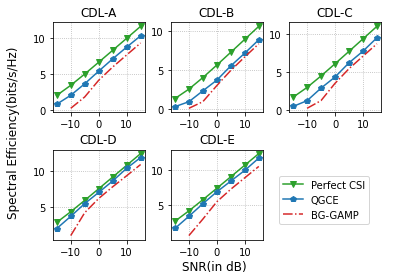

In [259]:
# plt.plot(SNR_vec,capacity_1bitQ_CDL_A/(ntest*nrepeat),'v-',label='CDL-A 1bit')
# plt.plot(SNR_vec,capacity_1bitQ_CDL_B/(ntest*nrepeat),'v-',label='CDL-B 1bit')
# plt.plot(SNR_vec,capacity_1bitQ_CDL_C/(ntest*nrepeat),'v-',label='CDL-C 1bit')
# plt.plot(SNR_vec,capacity_1bitQ_CDL_D/(ntest*nrepeat),'v-',label='CDL-D 1bit')
# plt.plot(SNR_vec,capacity_1bitQ_CDL_E/(ntest*nrepeat),'v-',label='CDL-E 1bit')
# plt.legend()

capacity_GAMP = sio.loadmat('results/capacity_GAMP.mat')
capacity_max = sio.loadmat('results/capacity_max.mat')
SNR_vec = range(-15,20,5)
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,capacity_max['capacity_CDL_A']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax1.plot(SNR_vec,capacity_1bitQ_CDL_A/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax1.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_A']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax1.grid(ls=':')
#ax1.set_xlim([-16,16]); ax1.set_ylim([-2.5,0]); ax1.set_xticks((-15,-5,5,15)); ax1.set_yticks([-2,-1])

ax2.plot(SNR_vec,capacity_max['capacity_CDL_B']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax2.plot(SNR_vec,capacity_1bitQ_CDL_B/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax2.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_B']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax2.grid(ls=':')
#ax2.set_xlim([-16,16]); ax2.set_ylim([-2.5,0]); ax2.set_xticks((-15,-5,5,15)); ax2.set_yticks([-2,-1])

ax3.plot(SNR_vec,capacity_max['capacity_CDL_C']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax3.plot(SNR_vec,capacity_1bitQ_CDL_C/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax3.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_C']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax3.grid(ls=':')
#ax3.set_xlim([-16,16]); ax3.set_ylim([-2.5,0]); ax3.set_xticks((-15,-5,5,15)); ax3.set_yticks([-2,-1])

ax4.plot(SNR_vec,capacity_max['capacity_CDL_D']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax4.plot(SNR_vec,capacity_1bitQ_CDL_D/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax4.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_D']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax4.grid(ls=':')
#ax4.set_xlim([-16,16]); ax4.set_ylim([-9.5,0]); ax4.set_xticks((-15,-5,5,15)); ax4.set_yticks([-7.5,-5,-2.5,0])

ax5.plot(SNR_vec,capacity_max['capacity_CDL_E']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax5.plot(SNR_vec,capacity_1bitQ_CDL_E/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax5.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_E']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax5.grid(ls=':')
#ax5.set_xlim([-16,16]); ax5.set_ylim([-9.5,0]); ax5.set_xticks((-15,-5,5,15)); ax5.set_yticks([-7.5,-5,-2.5,0])

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('Spectral Efficiency(bits/s/Hz)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7,0.2))
plt.savefig('results/1bitQ_capacity_SNR.pdf',dpi=50000)

In [241]:
capacity_1bitQ_CDL_C/(ntest*nrepeat)

array([[0.41285578],
       [1.17734926],
       [2.84203478],
       [4.31192118],
       [6.1927953 ],
       [7.73310376],
       [9.51352351]])

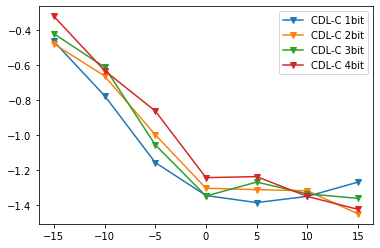

In [92]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='CDL-C 1bit')
plt.plot(SNR_vec,10*np.log10(nmse_2bitQ_CDL_C),'v-',label='CDL-C 2bit')
plt.plot(SNR_vec,10*np.log10(nmse_3bitQ_CDL_C),'v-',label='CDL-C 3bit')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_C),'v-',label='CDL-C 4bit')
plt.legend()

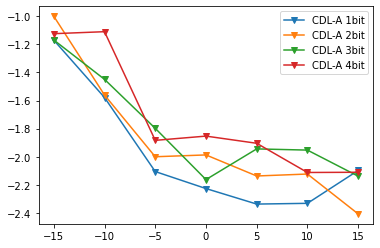

In [101]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_A),'v-',label='CDL-A 1bit')
plt.plot(SNR_vec,10*np.log10(nmse_2bitQ_CDL_A),'v-',label='CDL-A 2bit')
plt.plot(SNR_vec,10*np.log10(nmse_3bitQ_CDL_A),'v-',label='CDL-A 3bit')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_A),'v-',label='CDL-A 4bit')
plt.legend()

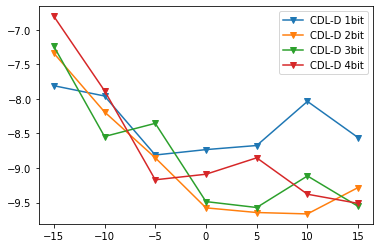

In [109]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_D),'v-',label='CDL-D 1bit')
plt.plot(SNR_vec,10*np.log10(nmse_2bitQ_CDL_D),'v-',label='CDL-D 2bit')
plt.plot(SNR_vec,10*np.log10(nmse_3bitQ_CDL_D),'v-',label='CDL-D 3bit')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_D),'v-',label='CDL-D 4bit')
plt.legend()

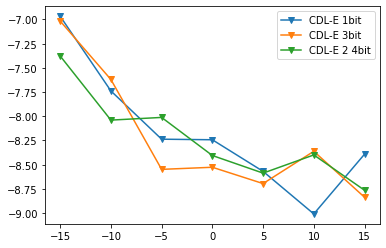

In [117]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_E),'v-',label='CDL-E 1bit')
plt.plot(SNR_vec,10*np.log10(nmse_3bitQ_CDL_E),'v-',label='CDL-E 3bit')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_E_2),'v-',label='CDL-E 2 4bit')
plt.legend()